# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, an image classifier is trained to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. The following dataset will be used: [dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


When the project is completed, we'll have an application that can be trained on any set of labeled images. Here the network will be learning about flowers and end up as a command line application. But, what what can be done with this CNN is limitted by your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

The program is run on Colab. So, we need to install torch first before running code. 

In [1]:
# http://pytorch.org/
from os.path import exists

from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision


tcmalloc: large alloc 1073750016 bytes == 0x59006000 @  0x7fe2b4f9e2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# Imports here all packages which will be needed for the program 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict
from google.colab import files

In [3]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL
from PIL import Image

    100% |████████████████████████████████| 5.6MB 6.9MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


## Load the data

 `torchvision` will be used to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If a pre-trained network is used, make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [4]:
#download a cat_dog dataset
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip


--2018-12-17 02:30:41--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.64.43
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.64.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  61.5MB/s    in 4.7s    

2018-12-17 02:30:46 (63.4 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]



In [5]:
#unzip the downloaded dataset
!unzip flower_data.zip;

Archive:  flower_data.zip
   creating: flower_data/
   creating: flower_data/valid/
   creating: flower_data/valid/61/
  inflating: flower_data/valid/61/image_06296.jpg  
  inflating: flower_data/valid/61/image_06293.jpg  
  inflating: flower_data/valid/61/image_06292.jpg  
  inflating: flower_data/valid/61/image_06261.jpg  
  inflating: flower_data/valid/61/image_06259.jpg  
  inflating: flower_data/valid/61/image_06273.jpg  
   creating: flower_data/valid/95/
  inflating: flower_data/valid/95/image_07513.jpg  
  inflating: flower_data/valid/95/image_07512.jpg  
  inflating: flower_data/valid/95/image_07510.jpg  
  inflating: flower_data/valid/95/image_07471.jpg  
  inflating: flower_data/valid/95/image_07475.jpg  
  inflating: flower_data/valid/95/image_07502.jpg  
  inflating: flower_data/valid/95/image_07588.jpg  
  inflating: flower_data/valid/95/image_07575.jpg  
  inflating: flower_data/valid/95/image_07585.jpg  
  inflating: flower_data/valid/95/image_07580.jpg  
  inflating: f

In [0]:
data_dir = 'flower_data'

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size=20
# percentage of training set to use as validation
valid_size = 0.2

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler,
                                          num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


### Label mapping

Mapping from a category label to a category name has to be loaded and it can be found in the file `cat_to_name.json`. It's a JSON object which can be read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
!wget https://github.com/debajyotiguha11/pytorch/archive/master.zip
!unzip master.zip;

--2018-12-17 02:30:54--  https://github.com/debajyotiguha11/pytorch/archive/master.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/debajyotiguha11/pytorch/zip/master [following]
--2018-12-17 02:30:55--  https://codeload.github.com/debajyotiguha11/pytorch/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.253.121, 192.30.253.120
Connecting to codeload.github.com (codeload.github.com)|192.30.253.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ]  45.42K  --.-KB/s    in 0.05s   

2018-12-17 02:30:55 (847 KB/s) - ‘master.zip’ saved [46513]

Archive:  master.zip
89b81789252bd7f59230cff4cef99ae7c603bedd
   creating: pytorch-master/
  inflating: pytorch-master/Ima

In [0]:
import json



with open('pytorch-master/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
classes = list(cat_to_name.values())


# Building and training the classifier

The data is ready, so it's time to build and train the classifier. One of the pretrained models from `torchvision.models` will be used to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters




Let's load in a model such as **`DenseNet`** and print out the architecture

In [9]:
arch = 'densenet121'
model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
#model

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 18848510.78it/s]


This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer (classifier): Linear(in_features=1024, out_features=1000). This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [10]:
#Check if parallel computing is available / if CUDA is available

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = "cuda"

CUDA is available!  Training on GPU ...


In [0]:


class Classifier(nn.Module):
    def __init__(self): #, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        self.input_size_out = 1024
        input_size = self.input_size_out
        hidden_layers = [768, 512, 256, 128]
        self.output_size_out = 102
        output_size = self.output_size_out
        drop_p = 0.2
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        

        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return x            #F.log_softmax(x, dim=1)








In [0]:

    
model.classifier = Classifier() 

model.to(device);

#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Let's train the classifier. For deep NN it is better to use GPU dseigned for matrix / tensor operations in parallel.  

### Specify Loss Function and Optimizer



In [0]:
learning_rate = 0.0001 * 0.5
momentum=0.9


# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate) #### # Only train the classifier parameters, feature parameters are frozen

### Train the network

In [58]:
epochs = 50
steps = 0
running_loss = 0
valid_loss = 0.0
valid_loss_min = np.Inf # track change in validation loss
print_every = 5
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        
#        if steps % print_every == 0:
    valid_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            valid_loss += batch_loss.item() * labels.size(0)

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(train_loader):.3f}.. "
          f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
          f"Validation accuracy: {100*accuracy/len(valid_loader):.3f}%")
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ... \n'.format(
        valid_loss_min/len(valid_loader),
        valid_loss/len(valid_loader)))
        model.class_to_idx = train_data.class_to_idx
 
        model.to('cpu')
        states = {
          'epoch': epoch+1,
          'arch' : arch,
          'class_to_idx': model.class_to_idx,  
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict()
#          'loss' :  running_loss,
#          'criterion' : criterion,  
#          'input_size': model.classifier.input_size_out,
#          'output_size': model.classifier.output_size_out,
#          'hidden_layers': [each.out_features for each in model.classifier.hidden_layers],
        }
        
        torch.save(states, 'checkpoint.pt')
        model.to(device)
        valid_loss_min = valid_loss 
    running_loss = 0

Epoch 1/50.. Train loss: 8.197.. Validation loss: 8.119.. Validation accuracy: 89.773%
Validation loss decreased (inf --> 8.119243).  Saving model ... 

Epoch 2/50.. Train loss: 8.403.. Validation loss: 8.724.. Validation accuracy: 88.712%
Epoch 3/50.. Train loss: 8.681.. Validation loss: 8.139.. Validation accuracy: 89.697%
Epoch 4/50.. Train loss: 7.958.. Validation loss: 8.086.. Validation accuracy: 90.000%
Validation loss decreased (8.119243 --> 8.085911).  Saving model ... 

Epoch 5/50.. Train loss: 8.642.. Validation loss: 8.525.. Validation accuracy: 89.848%
Epoch 6/50.. Train loss: 8.465.. Validation loss: 8.932.. Validation accuracy: 89.015%
Epoch 7/50.. Train loss: 8.018.. Validation loss: 8.448.. Validation accuracy: 89.394%
Epoch 8/50.. Train loss: 8.283.. Validation loss: 8.028.. Validation accuracy: 89.394%
Validation loss decreased (8.085911 --> 8.028321).  Saving model ... 

Epoch 9/50.. Train loss: 8.690.. Validation loss: 9.067.. Validation accuracy: 88.636%
Epoch 10/

KeyboardInterrupt: ignored

## Loading the checkpoint

Let's write a function that can load a checkpoint and rebuild the model, so we can come back to this project and keep working on it without having to retrain the network.

In [59]:
# https://discuss.pytorch.org/t/how-to-save-the-optimizer-setting-in-a-log-in-pytorch/17187/2
def checkpoint_loader(filename):
  
  checkpoint = torch.load(filename)
  
  model = models.densenet121(pretrained=False)
  for param in model.parameters():
    param.requires_grad = False
 
  # Put the classifier on the pretrained network
  model.classifier = Classifier()


  model.load_state_dict(checkpoint['state_dict'])
  model.to(device)
  
  return model

model = checkpoint_loader('checkpoint.pt')


model


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

## Inference for classification

Now we'll write a function to use a trained network for inference. An image will be passes into the network and predict the class of the flower in the image. We will write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. 

First let's processing the input image such that it can be used in the network. 

## Image Preprocessing

We'll use `PIL` to load the image and  write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

The following steps need to be done: 
First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We  want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. WE can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.


In [60]:
def process_image(image):
  ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
  '''
    
  pil_image = Image.open(image)
  # Process a PIL image for use in a PyTorch model
  w, h = pil_image.size
  if w == h:
    print('w=h')
    size = 256, 256
  elif w > h:
    print('w>h')
    ration = h / 256
    size = int(w/ratio), 256
  else:
    print('w < h')
    ratio = w / 256
    size = 256, int(h/ratio)
  
  print(w,h, ratio, size)
  #resize image:
  pil_image.thumbnail(size)
  
  # crop image
  np_im = np.array(pil_image)
  print(np_im.shape)
  np_im = np_im[(np_im.shape[0] - 224) // 2:(np_im.shape[0] - 224) // 2 + 224, (np_im.shape[1] - 224) // 2:(np_im.shape[1] - 224) // 2 + 224, :]

  print(np_im.shape)
  
  # normalize image
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  np_im = np_im / 255
  np_im = (np_im - mean) / std
  print("shape before transpose", np_im.shape)
  np_im = np.transpose(np_im, (2, 0, 1))
  
  print("shape after transpose", np_im.shape)
  return np_im

image = process_image('flower_data/valid/1/image_06739.jpg')

w < h
500 628 1.953125 (256, 321)
(321, 256, 3)
(224, 224, 3)
shape before transpose (224, 224, 3)
shape after transpose (3, 224, 224)


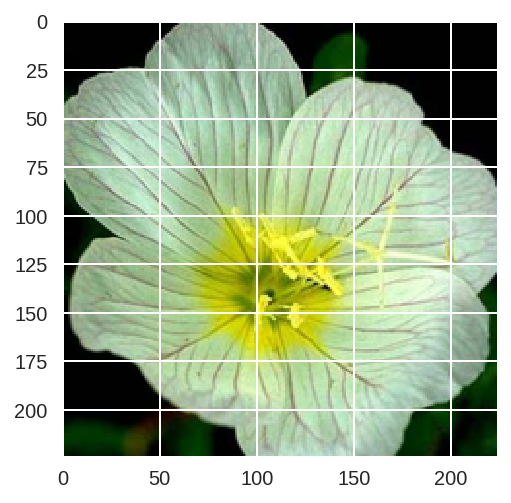

In [61]:
#To check the work, the function below converts a PyTorch tensor and displays it in the notebook. 
#If the process_image function works, running the output through this function should return the original image 
#(except for the cropped out portions).

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
  
imshow(image, ax=None, title=None)


## Class Prediction

Once we can get images in the correct format, it's time to write a function for making predictions with our model. We will predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.


```

In [62]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))
accuracy = 0

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
   
    # Calculate accuracy
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == target.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()



# average test loss
test_loss = test_loss/len(test_loader.dataset)
    
print(f"Validation loss: {test_loss/len(valid_loader):.3f}.. "
      f"Validation accuracy: {100*accuracy/len(test_loader):.2f}%")    


print("-------------=====Another approach to check accuracy=======----------------")


print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(102):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Validation loss: 0.005.. Validation accuracy: 93.16%
-------------=====Another approach to check accuracy=======----------------
Test Loss: 0.304880

Test Accuracy of fire lily: 87% ( 7/ 8)
Test Accuracy of canterbury bells: 100% ( 4/ 4)
Test Accuracy of bolero deep blue: 100% ( 6/ 6)
Test Accuracy of pink primrose: 100% ( 5/ 5)
Test Accuracy of mexican aster: 100% ( 6/ 6)
Test Accuracy of prince of wales feathers: 70% ( 7/10)
Test Accuracy of moon orchid: 80% ( 4/ 5)
Test Accuracy of globe-flower: 80% ( 4/ 5)
Test Accuracy of grape hyacinth: 100% ( 1/ 1)
Test Accuracy of corn poppy: 85% ( 6/ 7)
Test Accuracy of toad lily: 100% ( 2/ 2)
Test Accuracy of siam tulip: 100% (16/16)
Test Accuracy of red ginger: 100% (11/11)
Test Accuracy of spring crocus: 100% ( 4/ 4)
Test Accuracy of alpine sea holly: 100% ( 6/ 6)
Test Accuracy of garden phlox: 100% ( 7/ 7)
Test Accuracy of globe thistle: 100% ( 4/ 4)
Test Accuracy of tiger lily: 100% ( 8/ 8)
Test Accuracy of ball moss: 100% (12/12)
Test Ac

In [63]:
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

valid_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        valid_loss += batch_loss.item() * labels.size(0)

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
      f"Validation accuracy: {100*accuracy/len(valid_loader):.3f}%")

target.data[0]

Validation loss: 8.473.. Validation accuracy: 89.773%


tensor(99, device='cuda:0')

In [64]:
labels.view(*top_class.shape), top_class

(tensor([[49],
         [12],
         [86],
         [77],
         [77],
         [70],
         [74],
         [77],
         [96],
         [24]], device='cuda:0'), tensor([[49],
         [12],
         [86],
         [77],
         [77],
         [70],
         [74],
         [77],
         [96],
         [24]], device='cuda:0'))